<a href="https://colab.research.google.com/github/felixzhao/HARDataset/blob/main/Halter_V1_HAR_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib as mpl

In [3]:
import tensorflow as tf

In [4]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# Utilities

In [5]:
class HARDataSetLoader:
    def __init__(self, root_path):
        self.root = root_path
        self.file_dir = '/Inertial Signals/'
        self.file_prefix = ['total_acc_', 'body_acc_', 'body_gyro_']
        self.feature_type = ['x_', 'y_', 'z_']
        self.file_type = '.txt'
        self.num_classes = None

    def _get_feature_files_full_path(self, file_type:str):
        feature_files = []
        for prefix in self.file_prefix:
            for f_type in self.feature_type:
                full_path = f"{self.root}{file_type}{self.file_dir}" \
                            + f"{prefix}{f_type}{file_type}{self.file_type}"
                feature_files.append(full_path)
        return feature_files

    def _get_label_file_full_path(self, file_type:str):
        return f'{self.root}{file_type}/y_{file_type}.txt'

    def __load_file(self, file_path:str):
        return pd.read_csv(file_path, header=None, delim_whitespace=True).values

    def _load_feature(self, feature_files):
        features = np.dstack(
            [
                self.__load_file(f) for f in feature_files
            ]
        )
        return features

    def _load_label(self, label_file):
        labels = self.__load_file(label_file)
        self.num_classes = len(np.unique(labels))
        labels = labels - 1
        return tf.keras.utils.to_categorical(labels)

    def _load(self, split_type:str):
        feature_file_names = self._get_feature_files_full_path(split_type)
        label_file_name = self._get_label_file_full_path(split_type)
        print(feature_file_names)
        print(label_file_name)
        X = self._load_feature(feature_file_names)
        y = self._load_label(label_file_name)
        print(X.shape, y.shape)
        return X, y

    def load_train(self):
        print('load train data.')
        return self._load('train')

    def load_test(self):
        print('load test data.')
        return self._load('test')
  

# load data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
root_path = "drive/MyDrive/UCI_HAR_Dataset/"
loader = HARDataSetLoader(root_path=root_path)
X_train, y_train = loader.load_train()
X_test, y_test = loader.load_test()
print(f'{loader.num_classes=}')

load train data.
['drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/total_acc_x_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/total_acc_y_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/total_acc_z_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_acc_x_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_acc_y_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_acc_z_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_gyro_x_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_gyro_y_train.txt', 'drive/MyDrive/UCI_HAR_Dataset/train/Inertial Signals/body_gyro_z_train.txt']
drive/MyDrive/UCI_HAR_Dataset/train/y_train.txt
(7352, 128, 9) (7352, 6)
load test data.
['drive/MyDrive/UCI_HAR_Dataset/test/Inertial Signals/total_acc_x_test.txt', 'drive/MyDrive/UCI_HAR_Dataset/test/Inertial Signals/total_acc_y_test.txt', 'drive/MyDrive/UCI_HAR_Dataset/test/Inert

# Train LSTM model

In [8]:
train_shape = X_train.shape
batch_size = train_shape[0]
sequence_length = train_shape[1]
number_of_features = train_shape[2]
num_classes = loader.num_classes
print(f"{batch_size=}, {sequence_length=}, {number_of_features=}, {num_classes=} ")

batch_size=7352, sequence_length=128, number_of_features=9, num_classes=6 


In [9]:
learning_rate = 0.01
n_hidden = 32
batch_size = 64
shuffle_buffer_size = 1000
epochs = 30

## train model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, input_shape=(sequence_length, number_of_features)),
#   tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

#Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test) ,epochs=epochs)

Epoch 1/30
230/230 [==============================] - 7s 31ms/step - loss: 0.1370 - accuracy: 0.9448 - val_loss: 0.4209 - val_accuracy: 0.8914
Epoch 2/30
230/230 [==============================] - 7s 32ms/step - loss: 0.1148 - accuracy: 0.9513 - val_loss: 0.3753 - val_accuracy: 0.8962
Epoch 3/30
230/230 [==============================] - 8s 35ms/step - loss: 0.1145 - accuracy: 0.9521 - val_loss: 0.3842 - val_accuracy: 0.8884
Epoch 4/30
230/230 [==============================] - 8s 34ms/step - loss: 0.1298 - accuracy: 0.9453 - val_loss: 0.3909 - val_accuracy: 0.8941
Epoch 5/30
230/230 [==============================] - 8s 35ms/step - loss: 0.1103 - accuracy: 0.9528 - val_loss: 0.3608 - val_accuracy: 0.9006
Epoch 6/30
230/230 [==============================] - 8s 37ms/step - loss: 0.1049 - accuracy: 0.9535 - val_loss: 0.4325 - val_accuracy: 0.8867
Epoch 7/30
230/230 [==============================] - 7s 32ms/step - loss: 0.1005 - accuracy: 0.9558 - val_loss: 0.4531 - val_accuracy: 0.9036

## evaluate model

The LSTM accuracy from train set is 0.94, but from test set only 0.89.


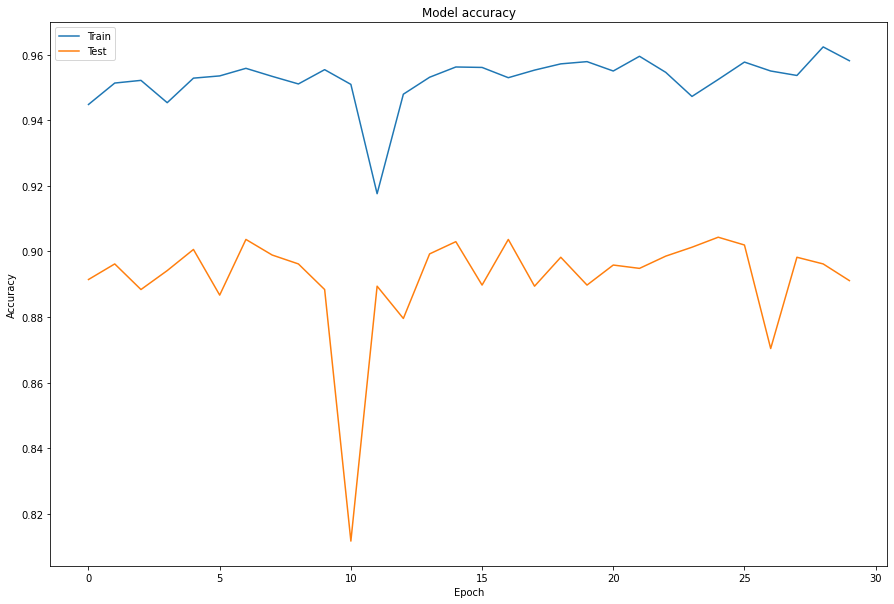

In [ ]:
fig = plt.figure(figsize=(15, 10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Train CNN + LSTM model

In [53]:
"""
padding='causal', 
    the input tensor is only padded on the left side, 
    and the output at time t only depends on past observations 
    and not on future observations. 
    This is useful in time series analysis.

strides=1, 
    the filter moves one step at a time along the width dimension, 
    and the output will have the same width as the input. 
    This means that the filter will be applied to every element of the input tensor, 
    resulting in the most detailed representation of the input. 
"""
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(
      filters=32, 
      kernel_size=4,
      strides=1,
      activation="relu",
      padding='causal',
      input_shape=(sequence_length, number_of_features),
      kernel_regularizer=tf.keras.regularizers.l2(0.001),
      ),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

#Print the model summary 
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 128, 32)           1184      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 6)                 390       
                                                                 
Total params: 12,006
Trainable params: 12,006
Non-trainable params: 0
_________________________________________________________________


In [54]:
# early_stop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
early_stop_acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-8, verbose=1)


# Train the model
history = model.fit(X_train, y_train ,validation_data=(X_test, y_test) ,epochs=50, callbacks=[early_stop_acc, reduce_lr])

Epoch 1/50
230/230 [==============================] - 11s 39ms/step - loss: 0.8454 - accuracy: 0.6133 - val_loss: 0.6273 - val_accuracy: 0.7211 - lr: 0.0100
Epoch 2/50
230/230 [==============================] - 9s 37ms/step - loss: 0.5256 - accuracy: 0.7734 - val_loss: 0.5194 - val_accuracy: 0.8310 - lr: 0.0100
Epoch 3/50
230/230 [==============================] - 9s 38ms/step - loss: 0.3852 - accuracy: 0.8702 - val_loss: 0.7166 - val_accuracy: 0.7391 - lr: 0.0100
Epoch 4/50
230/230 [==============================] - 10s 42ms/step - loss: 0.3364 - accuracy: 0.8961 - val_loss: 0.6705 - val_accuracy: 0.8493 - lr: 0.0100
Epoch 5/50
230/230 [==============================] - 9s 37ms/step - loss: 0.3680 - accuracy: 0.9026 - val_loss: 0.5444 - val_accuracy: 0.8748 - lr: 0.0100
Epoch 6/50
230/230 [==============================] - 9s 38ms/step - loss: 0.2737 - accuracy: 0.9289 - val_loss: 0.4759 - val_accuracy: 0.8904 - lr: 0.0100
Epoch 7/50
230/230 [==============================] - 9s 38ms/

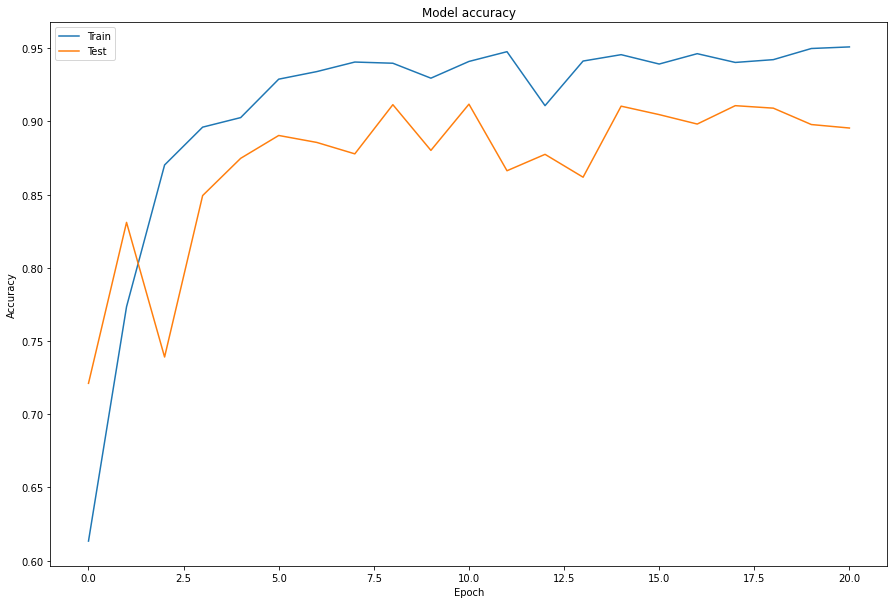

In [55]:
fig = plt.figure(figsize=(15, 10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [56]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

93/93 - 1s - loss: 0.3749 - accuracy: 0.9118 - 707ms/epoch - 8ms/step
Test accuracy: 0.9117746949195862


In [34]:
y_pred = model.predict(X_test)

93/93 [==============================] - 1s 9ms/step


In [35]:
y_pred_res = tf.argmax(y_pred, axis=1)
y_test_res = tf.argmax(y_test, axis=1)

In [36]:
cm = tf.math.confusion_matrix(y_test_res, y_pred_res, num_classes=num_classes)

In [37]:
class_names = [ 'WALKING',
    'WALKING_UPSTAIRS',
     'WALKING_DOWNSTAIRS',
     'SITTING',
     'STANDING',
     'LAYING',
]

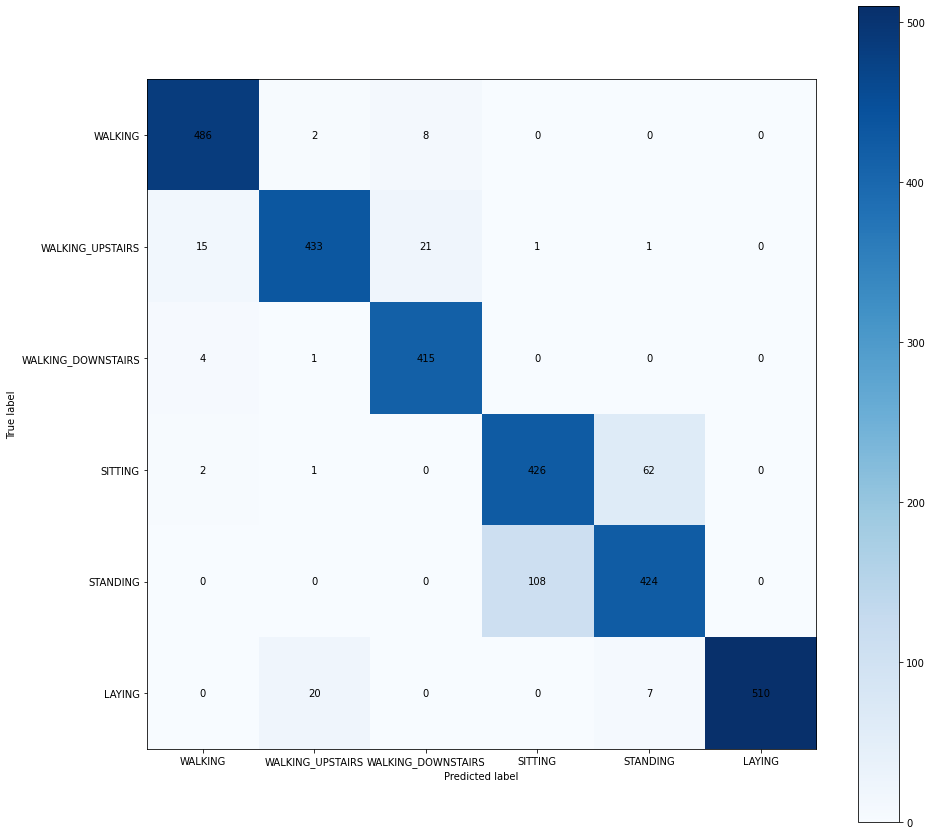

In [38]:
cm = np.array(cm)

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

## CNN + LSTM

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, input_shape=(sequence_length, number_of_features)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(number_of_classes, activation="softmax")
])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 32)           1184      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 12,006
Trainable params: 12,006
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

history = model.fit(X_train, y_train ,epochs=30)

Epoch 1/30
230/230 [==============================] - 16s 56ms/step - loss: 0.7394 - accuracy: 0.6721
Epoch 2/30
230/230 [==============================] - 17s 72ms/step - loss: 0.4052 - accuracy: 0.8474
Epoch 3/30
230/230 [==============================] - 13s 55ms/step - loss: 0.2520 - accuracy: 0.9155
Epoch 4/30
230/230 [==============================] - 13s 56ms/step - loss: 0.2384 - accuracy: 0.9142
Epoch 5/30
230/230 [==============================] - 13s 55ms/step - loss: 0.1833 - accuracy: 0.9309
Epoch 6/30
230/230 [==============================] - 13s 55ms/step - loss: 0.2275 - accuracy: 0.9192
Epoch 7/30
230/230 [==============================] - 14s 60ms/step - loss: 0.1530 - accuracy: 0.9400
Epoch 8/30
230/230 [==============================] - 13s 56ms/step - loss: 0.1538 - accuracy: 0.9436
Epoch 9/30
230/230 [==============================] - 13s 55ms/step - loss: 0.1834 - accuracy: 0.9324
Epoch 10/30
230/230 [==============================] - 13s 56ms/step - loss: 0.196

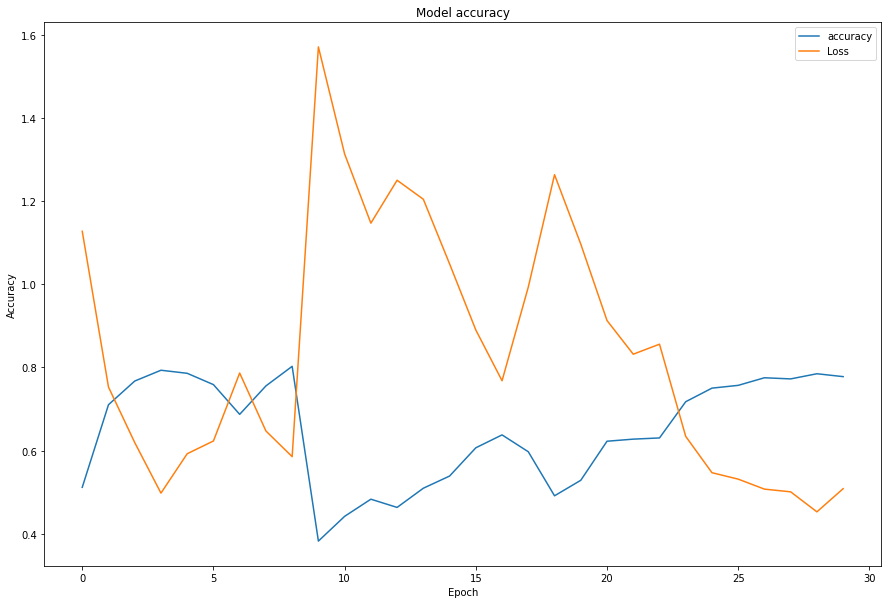

In [ ]:
# # Get mae and loss from history log
# mae=history.history['accuracy']
# loss=history.history['loss']

# # Get number of epochs
# epochs=range(len(loss)) 

# # Plot mae and loss
# plot_series(
#     x=epochs, 
#     y=(mae, loss), 
#     title='accuracy and Loss', 
#     xlabel='accuracy',
#     ylabel='Loss',
#     legend=['accuracy', 'Loss']
#     )

# Plot training & validation accuracy values
fig = plt.figure(figsize=(15, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'Loss'], loc='upper right')

# Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
score = model.evaluate(X_test, y_test)
score

93/93 [==============================] - 2s 15ms/step - loss: 0.4770 - accuracy: 0.9097


[0.4770335853099823, 0.9097387194633484]

In [ ]:
y_pred = model.predict(X_test)
y_pred_res = tf.argmax(y_pred, axis=1)

93/93 [==============================] - 2s 15ms/step


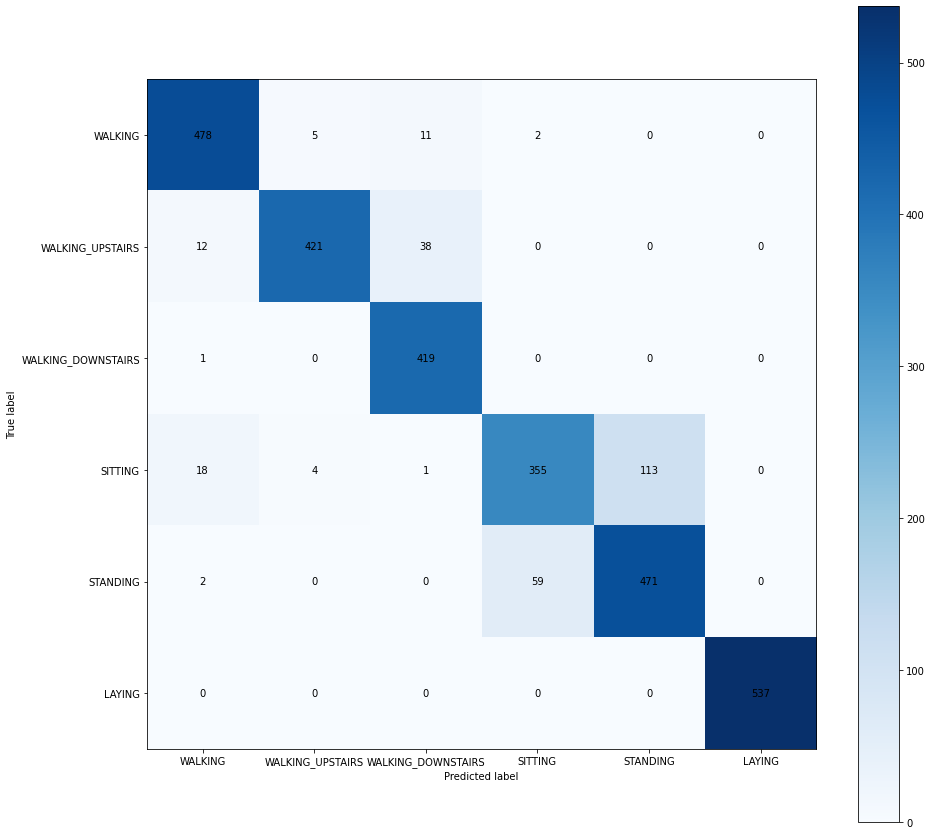

In [ ]:
cm = tf.math.confusion_matrix(y_test_res, y_pred_res, num_classes=num_classes)
cm = np.array(cm)

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

# GridSearchCV

We can use Grid Search CV to tuning the parameters of model. for example, tunning the regulariztion rate or dropout rate.


It takes too long to run thus here is the sample code, 

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from datetime import datetime

In [ ]:
def create_model(l2_rate=0.0):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                          strides=1,
                          activation="relu",
                          padding='causal',
                          input_shape=(sequence_length, number_of_features)),
      tf.keras.layers.LSTM(32),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_rate)),
      tf.keras.layers.Dense(number_of_classes, activation="softmax")
    ])
    model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )
    return model

# create the model
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)

<ipython-input-59-86912c2ff979>:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)


In [ ]:
# define the grid search parameters
l2_rate = [0.0, 0.1]#[0.0, 0.001, 0.01, 0.1]
param_grid = dict(l2_rate=l2_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

In [ ]:
start_time = datetime.now()

In [ ]:
grid_result = grid.fit(X_train, y_train)

In [ ]:
print(f'time cost: {datetime.now()-start_time}')

time cost: 0:00:07.428429


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Pros of LSTM for time series classification:

1. LSTMs are well suited for time series classification tasks as they are able to effectively capture long-term dependencies in sequential data.
2. LSTMs are able to handle input sequences of varying lengths, which is useful for handling variable-length time series data.
3. LSTMs are able to learn the underlying patterns and trends in the time series data, which can be useful for making accurate predictions.


## Cons of LSTM for time series classification:

1. LSTMs can be computationally expensive to train and run, particularly when dealing with large input sequences or large amounts of data.
2. LSTMs can be difficult to interpret and understand, as they are a complex model with many internal components.
3. LSTMs can be prone to overfitting if not properly regularized, as they have a large number of parameters that can be adjusted.
4. LSTMs may not be suitable for time series data with high frequency, as the model might not be able to capture the high-frequency patterns.
5. LSTMs may not be suitable for time series data with a high degree of noise, as the model might not be able to differentiate between noise and signal.